In [28]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [29]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


In [30]:
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# monthly rolling std
df['roll_std_21'] = df['log_ret'].rolling(21).std().shift(1)
# momentum
df['momentum'] = df['price'] - df['price'].shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_std_21,momentum,y_next_ret,y_up
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,0.008256,0.184872,-0.003565,0
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.008273,-0.357871,0.020804,1
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,0.008257,2.080956,-0.000154,0
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,0.009466,-0.015709,-0.014106,0
2021-02-05,100.650994,-0.014106,-0.014207,-0.000154,0.007176,0.009422,-1.440133,-0.003745,0


In [32]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5', 'roll_std_21', 'momentum']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

              precision    recall  f1-score   support

           0       0.56      0.81      0.66        53
           1       0.47      0.21      0.29        43

    accuracy                           0.54        96
   macro avg       0.52      0.51      0.48        96
weighted avg       0.52      0.54      0.50        96



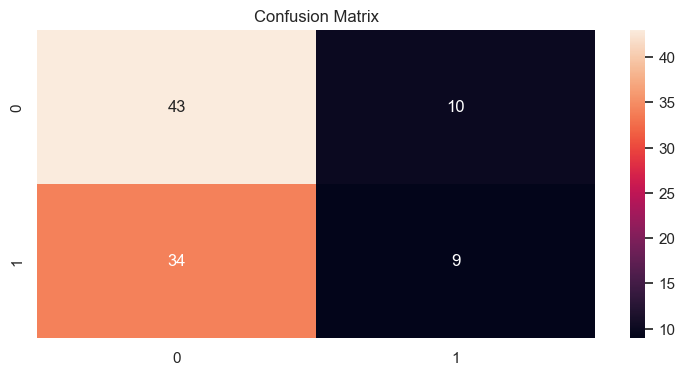

In [33]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

In [34]:
# The accuracy improved from 0.52 to 0.54 after adding the momentum and rolling std factor. The assumption is that there is a momentum factor, but it may fail if the market is actually mean reverting. I can add more features like the cross between Moving Averages of different time period to further improve the model.